In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skfuzzy import cmeans
import glob

In [2]:
import os

# Local dataset root (no external download)
dataset_root = os.path.join(os.getcwd(), "data", "KRD WBC Dataset")
if not os.path.isdir(dataset_root):
    raise FileNotFoundError(f"Dataset not found at: {dataset_root}")

print("Using dataset:", dataset_root)
print("Available splits:", [d for d in os.listdir(dataset_root) if os.path.isdir(os.path.join(dataset_root, d))])

Using dataset: c:\Github\DLMI_assignments\data\KRD WBC Dataset
Available splits: ['train', 'val']


In [3]:
class WBCDataLoader:
    def __init__(self, dataset_path, split="train", img_size=(200, 200)):
        self.img_dir = os.path.join(dataset_path, split, "images")
        self.mask_dir = os.path.join(dataset_path, split, "mask")
        self.img_size = img_size

        if not os.path.isdir(self.img_dir):
            raise FileNotFoundError(f"Image directory not found: {self.img_dir}")
        if not os.path.isdir(self.mask_dir):
            raise FileNotFoundError(f"Mask directory not found: {self.mask_dir}")

        image_paths = []
        for ext in ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.tif", "*.tiff"):
            image_paths.extend(glob.glob(os.path.join(self.img_dir, ext)))

        self.samples = []
        for img_path in sorted(image_paths):
            stem = os.path.splitext(os.path.basename(img_path))[0]
            mask_matches = glob.glob(os.path.join(self.mask_dir, f"{stem}.*"))
            if mask_matches:
                self.samples.append((img_path, mask_matches[0]))

        print(f"[{split}] Found {len(self.samples)} image-mask pairs")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_size)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)
        mask = (mask > 0).astype(np.uint8)

        return img, mask

# Initialize dataloaders from local dataset
train_loader = WBCDataLoader(dataset_root, split="train")
val_loader = WBCDataLoader(dataset_root, split="val")
dataloader = val_loader

[train] Found 480 image-mask pairs
[val] Found 119 image-mask pairs


In [4]:
def segment_kmeans(img, n_clusters=3):
    pixels = img.reshape((-1, 3)).astype(np.float32)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixels)
    return labels.reshape(img.shape[:2])

def segment_fcm(img, n_clusters=3):
    pixels = img.reshape((-1, 3)).T.astype(np.float64)
    cntr, u, u0, d, jm, p, fpc = cmeans(pixels, n_clusters, 2, error=0.005, maxiter=1000)
    labels = np.argmax(u, axis=0)
    return labels.reshape(img.shape[:2])

In [5]:
def labels_to_cell_mask(img, labels):
    """Convert cluster labels into a single WBC mask (nucleus + cytoplasm)."""
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h = hsv[..., 0].astype(np.uint8)
    s = hsv[..., 1].astype(np.uint8)
    v = hsv[..., 2].astype(np.uint8)

    # Purple-ish prior for WBC (OpenCV H range: 0..179)
    purple_prior = ((h >= 115) & (h <= 170) & (s >= 45) & (v <= 210)).astype(np.uint8)

    n_clusters = int(labels.max()) + 1
    cluster_scores = []
    for k in range(n_clusters):
        region = (labels == k)
        if not np.any(region):
            cluster_scores.append(-np.inf)
            continue

        overlap = float(np.mean(purple_prior[region]))
        mean_sat = float(np.mean(s[region])) / 255.0
        mean_val = float(np.mean(v[region])) / 255.0

        # Prefer clusters aligned with purple prior and not too bright
        score = (2.8 * overlap) + (0.8 * mean_sat) - (0.6 * mean_val)
        cluster_scores.append(score)

    best_cluster = int(np.argmax(cluster_scores))
    candidate = (labels == best_cluster).astype(np.uint8)

    # Stronger cleanup to disconnect thin ring artifacts
    kernel3 = np.ones((3, 3), np.uint8)
    kernel5 = np.ones((5, 5), np.uint8)
    candidate = cv2.morphologyEx(candidate, cv2.MORPH_OPEN, kernel5)
    candidate = cv2.morphologyEx(candidate, cv2.MORPH_CLOSE, kernel3)

    num_cc, cc_map, stats, centroids = cv2.connectedComponentsWithStats(candidate, connectivity=8)
    if num_cc <= 1:
        return candidate

    h_img, w_img = candidate.shape
    center = np.array([w_img / 2.0, h_img / 2.0], dtype=np.float32)

    best_label = 0
    best_score = -np.inf

    for cc in range(1, num_cc):
        region = (cc_map == cc)
        area = int(stats[cc, cv2.CC_STAT_AREA])
        if area < 120:
            continue

        w = max(int(stats[cc, cv2.CC_STAT_WIDTH]), 1)
        h_box = max(int(stats[cc, cv2.CC_STAT_HEIGHT]), 1)
        bbox_area = float(w * h_box)
        fill_ratio = area / bbox_area

        centroid = centroids[cc]
        dist = float(np.linalg.norm(centroid - center))
        mean_prior = float(np.mean(purple_prior[region]))

        # Prefer purple, compact, reasonably large, and near-center components
        score = (3.0 * mean_prior) + (2.2 * fill_ratio) + (0.002 * area) - (0.06 * dist)
        if score > best_score:
            best_score = score
            best_label = cc

    if best_label == 0:
        return candidate

    wbc_mask = (cc_map == best_label).astype(np.uint8)
    wbc_mask = cv2.morphologyEx(wbc_mask, cv2.MORPH_CLOSE, kernel3)
    return wbc_mask

def extract_boundary(binary_mask):
    """Extract boundary from binary mask using morphological gradient."""
    kernel = np.ones((3, 3), np.uint8)
    boundary = cv2.morphologyEx(binary_mask.astype(np.uint8), cv2.MORPH_GRADIENT, kernel)
    return (boundary > 0).astype(np.uint8)

def calculate_boundary_metrics(boundary_gt, boundary_pred):
    """Calculate accuracy, precision, recall, F1 for boundary comparison."""
    TP = np.logical_and(boundary_gt, boundary_pred).sum()
    TN = np.logical_and(~boundary_gt.astype(bool), ~boundary_pred.astype(bool)).sum()
    FP = np.logical_and(~boundary_gt.astype(bool), boundary_pred).sum()
    FN = np.logical_and(boundary_gt, ~boundary_pred.astype(bool)).sum()

    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

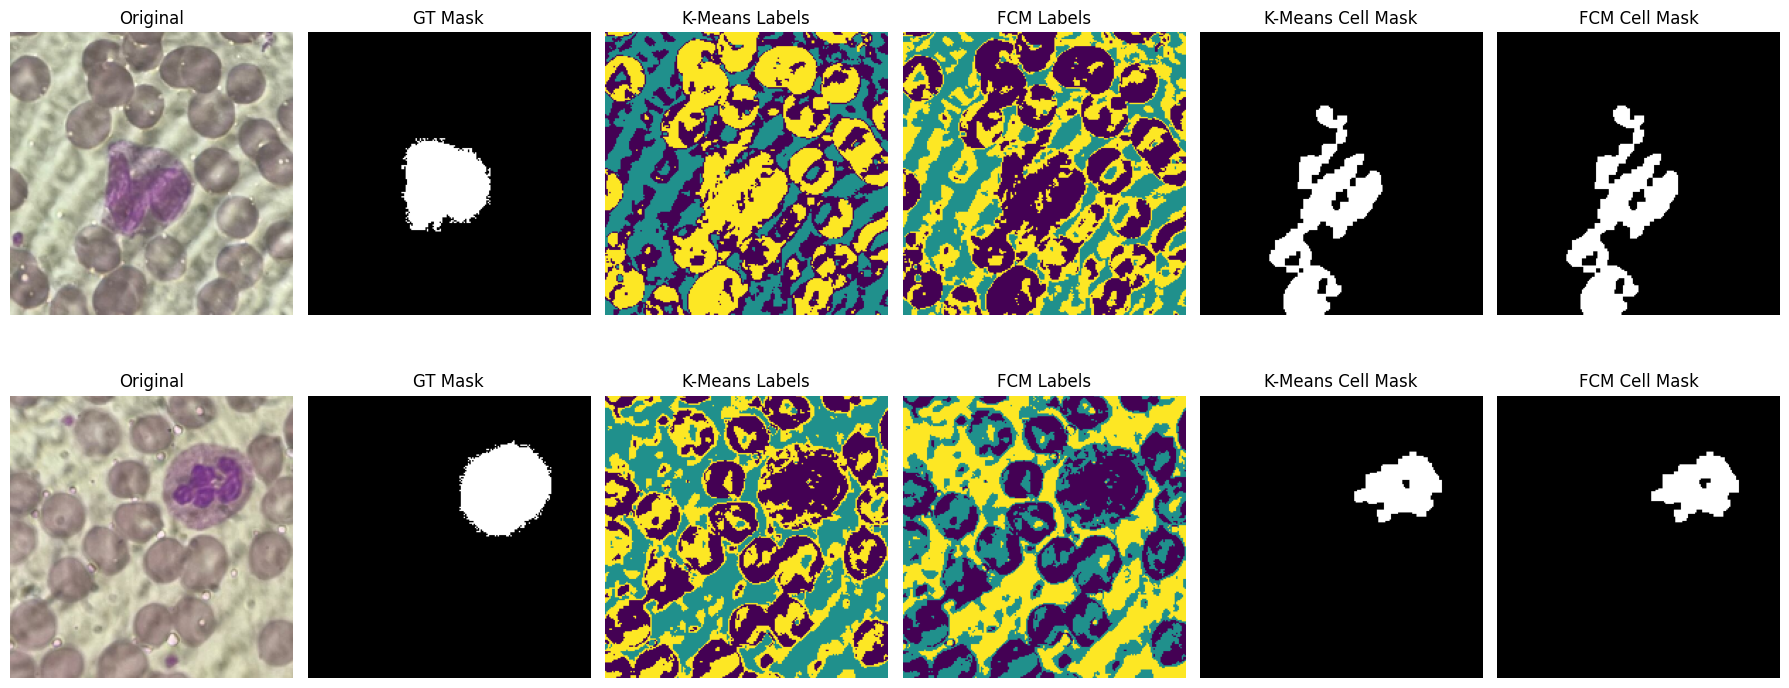

In [6]:
# Visualize 2 random samples with predicted cell masks
num_samples = min(2, len(dataloader))
random_indices = np.random.choice(len(dataloader), num_samples, replace=False)
fig, axes = plt.subplots(num_samples, 6, figsize=(18, 4 * num_samples))
if num_samples == 1:
    axes = np.expand_dims(axes, axis=0)

for idx, i in enumerate(random_indices):
    img, mask = dataloader[i]

    kmeans_labels = segment_kmeans(img, n_clusters=3)
    fcm_labels = segment_fcm(img, n_clusters=3)

    kmeans_mask = labels_to_cell_mask(img, kmeans_labels)
    fcm_mask = labels_to_cell_mask(img, fcm_labels)

    axes[idx, 0].imshow(img)
    axes[idx, 0].set_title("Original")
    axes[idx, 0].axis("off")

    axes[idx, 1].imshow(mask, cmap="gray")
    axes[idx, 1].set_title("GT Mask")
    axes[idx, 1].axis("off")

    axes[idx, 2].imshow(kmeans_labels, cmap="viridis")
    axes[idx, 2].set_title("K-Means Labels")
    axes[idx, 2].axis("off")

    axes[idx, 3].imshow(fcm_labels, cmap="viridis")
    axes[idx, 3].set_title("FCM Labels")
    axes[idx, 3].axis("off")

    axes[idx, 4].imshow(kmeans_mask, cmap="gray")
    axes[idx, 4].set_title("K-Means Cell Mask")
    axes[idx, 4].axis("off")

    axes[idx, 5].imshow(fcm_mask, cmap="gray")
    axes[idx, 5].set_title("FCM Cell Mask")
    axes[idx, 5].axis("off")

plt.tight_layout()
plt.show()

In [18]:
kmeans_scores = {"accuracy": [], "precision": [], "recall": [], "f1_score": []}
fcm_scores = {"accuracy": [], "precision": [], "recall": [], "f1_score": []}

for i in range(len(dataloader)):
    img, mask = dataloader[i]

    kmeans_labels = segment_kmeans(img, n_clusters=3)
    fcm_labels = segment_fcm(img, n_clusters=3)

    kmeans_mask = labels_to_cell_mask(img, kmeans_labels)
    fcm_mask = labels_to_cell_mask(img, fcm_labels)

    gt_boundary = extract_boundary(mask)
    kmeans_boundary = extract_boundary(kmeans_mask)
    fcm_boundary = extract_boundary(fcm_mask)

    km = calculate_boundary_metrics(gt_boundary, kmeans_boundary)
    fm = calculate_boundary_metrics(gt_boundary, fcm_boundary)

    for key in kmeans_scores:
        kmeans_scores[key].append(km[key])
        fcm_scores[key].append(fm[key])

print("K-Means Boundary Metrics (dataset average)")
for key, values in kmeans_scores.items():
    print(f"  {key}: {np.mean(values):.4f}")

print("\nFuzzy C-Means Boundary Metrics (dataset average)")
for key, values in fcm_scores.items():
    print(f"  {key}: {np.mean(values):.4f}")

K-Means Boundary Metrics (dataset average)
  accuracy: 0.9691
  precision: 0.2504
  recall: 0.2672
  f1_score: 0.2446

Fuzzy C-Means Boundary Metrics (dataset average)
  accuracy: 0.9698
  precision: 0.2513
  recall: 0.2666
  f1_score: 0.2456
